
Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Processing...
Done!
torch.Size([64, 1, 28, 28])
torch.Size([64])


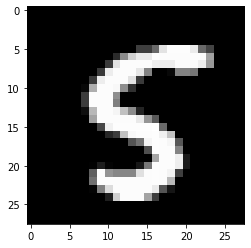

In [ ]:
# importing the libraries
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
%matplotlib inline


# transformations to be applied on images
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
# defining the training and testing set
trainset = datasets.MNIST('./data', download=True, train=True, transform=transform)
testset = datasets.MNIST('./', download=True, train=False, transform=transform)
# defining trainloader and testloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)
# shape of training data
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)
# visualizing the training images
plt.imshow(images[0].numpy().squeeze(), cmap='gray')

In [ ]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=2)

        self.fc1 = nn.Linear(in_features=8*4*4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)

    def forward(self, t):
        # print(len(t),len(t[0]),len(t[0][0]),len(t[0][0][0]))
        # (1) hidden conv layer
        t = torch.fft.fft(t).abs()
        t1 = self.conv1(t)
        t1 = F.relu(t1)
        t1 = F.max_pool2d(t1, kernel_size=2, stride=2)
        # print(len(t),len(t[0]),len(t[0][0]),len(t[0][0][0]))

        # (2) hidden conv layer
        t2 = self.conv2(t1)
        t2 = F.relu(t2)
        t2 = F.max_pool2d(t2, kernel_size=2, stride=2)
        # print(len(t),len(t[0]),len(t[0][0]),len(t[0][0][0]))

        # (3) hidden conv layer
        t3 = self.conv3(t2)
        t3 = F.relu(t3)
        t3 = F.max_pool2d(t3, kernel_size=2, stride=2)
        # print(len(t),len(t[0]),len(t[0][0]),len(t[0][0][0]))

        # (4) hidden linear layer
        t = t3.reshape(-1, 8 * 4 * 4)
        t = self.fc1(t)
        t = F.relu(t)
        # print(len(t),len(t[0]))

        # (5) hidden linear layer
        t = self.fc2(t)
        t = F.relu(t)

        # (6) output layer
        t = self.out(t)
        # t = F.softmax(t, dim=1)
        # print(len(t),len(t[0]))


        return [t,t1,t2,t3]



In [ ]:
model = Network()
optimizer = optim.Adam(model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

In [ ]:
from torchsummary import summary
print(model)
print(summary(model, (1,28,28)))

Network(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=128, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
            Conv2d-2            [-1, 8, 14, 14]           1,160
            Conv2d-3              [-1, 8, 9, 9]             584
            Linear-4                  [-1, 120]          15,480
            Linear-5                   [-1, 60]           7,260
            Linear-6                   [-1, 10]             610
Total params: 25,254
Trainable params: 25,254
Non-trainable params

In [ ]:
for i in range(15):
    running_loss = 0
    for images, labels in trainloader:

        if torch.cuda.is_available():
          images = images.cuda()
          labels = labels.cuda()

        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        # print(output)
        # print(labels)
        loss = criterion(output[0], labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        print("Epoch {} - Training loss: {}".format(i+1, running_loss/len(trainloader)))

Epoch 1 - Training loss: 0.4072006664900129
Epoch 2 - Training loss: 0.2426529287465854
Epoch 3 - Training loss: 0.226405136148209
Epoch 4 - Training loss: 0.2151924658026586
Epoch 5 - Training loss: 0.209053886871634
Epoch 6 - Training loss: 0.2042754194689299
Epoch 7 - Training loss: 0.1982827767638414
Epoch 8 - Training loss: 0.1985171454738198
Epoch 9 - Training loss: 0.1982226503262324
Epoch 10 - Training loss: 0.1957190694815632
Epoch 11 - Training loss: 0.192047127816421
Epoch 12 - Training loss: 0.1890201755801339
Epoch 13 - Training loss: 0.18956470021259175
Epoch 14 - Training loss: 0.19184631350110654
Epoch 15 - Training loss: 0.18261174434847605


In [ ]:
 # getting predictions on test set and measuring the performance

correct_count, all_count = 0, 0
for images,labels in trainloader:
  for i in range(len(labels)):
    if torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()
    img = images[i].view(1, 1, 28, 28)
    with torch.no_grad():
        logps = model(img)

    
    ps = torch.exp(logps[0])
    probab = list(ps.cpu()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.cpu()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Training Accuracy =", (correct_count/all_count))


correct_count, all_count = 0, 0
for images,labels in testloader:
  for i in range(len(labels)):
    if torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()
    img = images[i].view(1, 1, 28, 28)
    with torch.no_grad():
        logps = model(img)

    
    ps = torch.exp(logps[0])
    probab = list(ps.cpu()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.cpu()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))
# 0.9389 with relu , loss = 0.036
# 0.9228 , loss = 0.274
# 0.9286 , loss = 0.071

# 0.9536, 0.9531 with relu , l = 0.038
# 0.9698, 0.9696 0.5relu , l = 0.197
# 0.9266, 0.9245, l = 0.275

# Ae+mlp relu 0.965
# Ae+mlp with silu Model Training Accuracy = 0.9873  Model Accuracy = 0.9853

Number Of Images Tested = 60000

Model Training Accuracy = 0.9450333333333333
Number Of Images Tested = 10000

Model Accuracy = 0.9408


In [ ]:
#Define the Convolutional Autoencoder
class ConvAutoencoder1(nn.Module):
    def __init__(self, inp, kern):
        super(ConvAutoencoder1, self).__init__()
        self.inp = inp
        #Encoder
        self.conv1 = nn.Conv2d(self.inp, 16, 3, padding=1)  
        self.conv2 = nn.Conv2d(16, 8, 3, padding=1)
        self.conv3 = nn.Conv2d(8, 4, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
       
        #Decoder
        self.t_conv1 = nn.ConvTranspose2d(4, 8, 3, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(8, 16, 3, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(16, self.inp, kern, stride=2)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # print('a',len(output), len(output[0]), len(output[0][0]), len(output[0][0][0]))
        # print('b11',len(x), len(x[0]), len(x[0][0]), len(x[0][0][0]))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        # print('b12',len(x), len(x[0]), len(x[0][0]), len(x[0][0][0]))
        x = F.relu(self.conv3(x))
        x1 = self.pool(x)
        # print('b13',len(x), len(x[0]), len(x[0][0]), len(x[0][0][0]))
        x = F.relu(self.t_conv1(x1))
        # print('b14',len(x), len(x[0]), len(x[0][0]), len(x[0][0][0]))
        x = F.relu(self.t_conv2(x))
        # print('b15',len(x), len(x[0]), len(x[0][0]), len(x[0][0][0]))
        x = self.t_conv3(x)
        return x,(x1)

In [ ]:
model_mid1 = ConvAutoencoder1(16,2)
optimizer = optim.Adam(model_mid1.parameters(), lr=0.001)
criterion = nn.MSELoss()
if torch.cuda.is_available():
    model_mid1 = model_mid1.cuda()
    criterion = criterion.cuda()

In [ ]:


for i in range(15):
    running_loss = 0
    for images, labels in trainloader:

        if torch.cuda.is_available():
          images = images.cuda()
          labels = labels.cuda()

        # reference = torch.zeros_like(images)
        # print(len(reference), len(reference[0]), len(reference[0][0]), len(reference[0][0][0]))
        
        # Training pass
        optimizer.zero_grad()
        
        output1 = model(images)
        # print('a',len(output), len(output[0]), len(output[0][0]), len(output[0][0][0]))
        # print('b',len(output1[1]), len(output1[1][0]), len(output1[1][0][0]), len(output1[1][0][0]))
        output,_ = model_mid1(output1[1])
        # print(output)
        # print(labels)
        # print('a',len(output), len(output[0]), len(output[0][0]), len(output[0][0][0]))
        # print('b',len(output1[1]), len(output1[1][0]), len(output1[1][0][0]), len(output1[1][0][0]))
        # break
        loss = criterion(output1[1], output)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(i+1, running_loss/len(trainloader)))
    

Epoch 1 - Training loss: 1.0750378874827549
Epoch 2 - Training loss: 0.6005953200526838
Epoch 3 - Training loss: 0.5641562914225593
Epoch 4 - Training loss: 0.5564299388480848
Epoch 5 - Training loss: 0.5528592297962225
Epoch 6 - Training loss: 0.5501957884602455
Epoch 7 - Training loss: 0.5485219788640293
Epoch 8 - Training loss: 0.5468163243743148
Epoch 9 - Training loss: 0.5446579033123659
Epoch 10 - Training loss: 0.5427331988936039
Epoch 11 - Training loss: 0.5406140072195769
Epoch 12 - Training loss: 0.539119493510169
Epoch 13 - Training loss: 0.5371171716116131
Epoch 14 - Training loss: 0.5358096935601631
Epoch 15 - Training loss: 0.5348255431918956


In [ ]:
error=[]
l_norm=[]
device='cuda'
for X,y in testloader:
    X,y = X.to(device), y.to(device)
    for i in range(len(X)):
        # true = y[i]
        t=model((X[i]).reshape(1,1,28,28))
        t1,t2 = model_mid1(t[1])
        l_norm.append(torch.norm(t2).detach().cpu())
        error.append(nn.MSELoss()(t1,t[1]).detach().cpu())

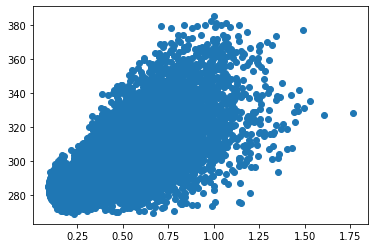

In [ ]:
plt.scatter(error,l_norm)
plt.show()

In [ ]:
#Define the Convolutional Autoencoder
class ConvAutoencoder2(nn.Module):
    def __init__(self):
        super(ConvAutoencoder2, self).__init__()
        #Encoder
        self.conv1 = nn.Conv2d(8, 16, 3, padding=1)  
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
       
        #Decoder
        self.t_conv1 = nn.ConvTranspose2d(16, 16, 3, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 16, 3, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(16, 8, 3, stride=2)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # print('a',len(output), len(output[0]), len(output[0][0]), len(output[0][0][0]))
        # print('b11',len(x), len(x[0]), len(x[0][0]), len(x[0][0][0]))
        x = F.relu(self.conv2(x))
        # x = self.pool(x)
        # print('b12',len(x), len(x[0]), len(x[0][0]), len(x[0][0][0]))
        x = F.relu(self.conv3(x))
        x1 = self.pool(x)
        # print('b13',len(x1), len(x1[0]), len(x1[0][0]), len(x1[0][0][0]))
        x = F.relu(self.t_conv1(x1))
        # print('b14',len(x), len(x[0]), len(x[0][0]), len(x[0][0][0]))
        x = (F.relu(self.t_conv2(x)))
        # print('b15',len(x), len(x[0]), len(x[0][0]), len(x[0][0][0]))
        x = self.t_conv3(x)
        x = self.pool(x)
        return x,x1

In [ ]:
model_mid2 = ConvAutoencoder2()
optimizer = optim.Adam(model_mid2.parameters(), lr=0.005)
criterion = nn.MSELoss()
if torch.cuda.is_available():
    model_mid2 = model_mid2.cuda()
    criterion = criterion.cuda()

In [ ]:


for i in range(20):
    running_loss = 0
    for images, labels in trainloader:

        if torch.cuda.is_available():
          images = images.cuda()
          labels = labels.cuda()

        # reference = torch.zeros_like(images)
        # print(len(reference), len(reference[0]), len(reference[0][0]), len(reference[0][0][0]))
        
        # Training pass
        optimizer.zero_grad()
        
        output1 = model(images)
        output,_ = model_mid2(output1[2])
        # print(output)
        # print(labels)
        # print('a',len(output), len(output[0]), len(output[0][0]), len(output[0][0][0]))
        # print('b',len(output1[2]), len(output1[2][0]), len(output1[2][0][0]), len(output1[2][0][0]))
        # break
        loss = criterion(output1[2], output)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(i+1, running_loss/len(trainloader)))
    

Epoch 1 - Training loss: 2.696235087253392
Epoch 2 - Training loss: 1.2660611470116736
Epoch 3 - Training loss: 1.1610631553857311
Epoch 4 - Training loss: 1.1150025166173987
Epoch 5 - Training loss: 1.0859133439150446
Epoch 6 - Training loss: 1.0620145242986903
Epoch 7 - Training loss: 1.0478407168057935
Epoch 8 - Training loss: 1.0353034723923404
Epoch 9 - Training loss: 1.0264559485383633
Epoch 10 - Training loss: 1.0178980503255115
Epoch 11 - Training loss: 1.0091688890955341
Epoch 12 - Training loss: 1.0034022049100668
Epoch 13 - Training loss: 0.9983989050520509
Epoch 14 - Training loss: 0.9895619898081334
Epoch 15 - Training loss: 0.9847861744447558
Epoch 16 - Training loss: 0.9799591586279717
Epoch 17 - Training loss: 0.9752184617748139
Epoch 18 - Training loss: 0.9702600984176847
Epoch 19 - Training loss: 0.9693899927998403
Epoch 20 - Training loss: 0.9660112663372747


In [ ]:
def fgsm(model, X, y, epsilon):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta)[0], y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

def plot_images(X,y,yp,M,N):
    f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(N,M*1.3))
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(1-X[i*N+j][0].cpu().numpy(), cmap="gray")
            title = ax[i][j].set_title("Pred: {}".format(yp[i*N+j]))
            plt.setp(title, color=('g' if yp[i*N+j] == y[i*N+j] else 'r'))
            ax[i][j].set_axis_off()
    plt.tight_layout()


In [ ]:
res = np.array([0,0,0,0])
correct_model2 = 0
adversaries = 0
nonadv = 0
abc1=[]
abc2=[]
abc3=[]
abc4=[]
for X,y in testloader:
    X,y = X.to(device), y.to(device)
    delta = fgsm(model, X, y, 0.1)
    for i in range(len(X)):
        # t1,t2=model((X[i]).reshape(1,1,28,28))
        # a = torch.argmax(t1).item()
        true = y[i]
        # print('ori', a )
        t1=model((X[i]+delta[i]).reshape(1,1,28,28))
        b = torch.argmax(t1[0]).item()
        # print('adv', b )
        # print(len(ref[0]),len(ref[0][0]),len(ref[0][0][0]),)
        # print(len(out),len(out[0]),len(out[0][0]),)
        # losses = np.array([nn.MSELoss()(ref[j].reshape(1,1,28,28),out) for j in range(len(ref))])
        # print(losses)
        # break
        # c = np.argmin(losses)

        # t1,t2=model(out.reshape(1,1,28,28))
        # c = torch.argmax(t1).item()
        # print('dec', c )
        # print('\n')
        if(true!=b):
            adversaries+=1
            t2,t3=model_mid1(t1[1])
            abc1.append(nn.MSELoss()(t2,t1[1]).detach().cpu())
            abc2.append(torch.norm(t3).detach().cpu())
        else:
            t2,t3=model_mid1(t1[1])
            abc3.append(nn.MSELoss()(t2,t1[1]).detach().cpu())
            abc4.append(torch.norm(t3).detach().cpu())
#                 res[0]+=1
#             else:
#                 res[1]+=1
#         else:
#             adversaries+=1
#             if(true==c):
#                 correct_model2+=1
#             if(b==c):
#                 res[2]+=1
#             else:
#                 res[3]+=1
# print(res, correct_model2, adversaries, nonadv)
'''0 - correct guess by both models 
1 - correct by model1 but wrong by model2 
2 - wrong by model1 but correct by model2 
3 - wrong by both models'''
print(adversaries)

3531


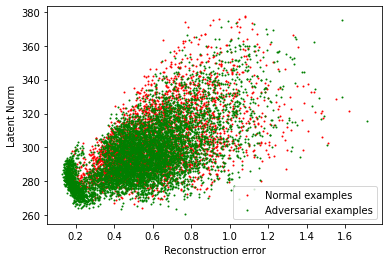

In [ ]:
# plt.scatter(error,l_norm)
plt.scatter(abc1,abc2, color='red',s=1)
plt.scatter(abc3,abc4, color='green',s=1)
plt.xlabel('Reconstruction error')
plt.ylabel('Latent Norm')
plt.legend(['Normal examples', 'Adversarial examples'])
plt.show()

In [ ]:
error2=[]
l_norm2=[]
device='cuda'
for X,y in testloader:
    X,y = X.to(device), y.to(device)
    for i in range(len(X)):
        # true = y[i]
        t=model((X[i]).reshape(1,1,28,28))
        t1,t2 = model_mid2(t[2])
        l_norm2.append(torch.norm(t2).detach().cpu())
        error2.append(nn.MSELoss()(t1,t[2]).detach().cpu())

In [ ]:
res = np.array([0,0,0,0])
correct_model2 = 0
adversaries = 0
nonadv = 0
abc1=[]
abc2=[]
abc3=[]
abc4=[]
for X,y in testloader:
    X,y = X.to(device), y.to(device)
    delta = fgsm(model, X, y, 0.1)
    for i in range(len(X)):
        # t1,t2=model((X[i]).reshape(1,1,28,28))
        # a = torch.argmax(t1).item()
        true = y[i]
        # print('ori', a )
        t1=model((X[i]+delta[i]).reshape(1,1,28,28))
        b = torch.argmax(t1[0]).item()
        # print('adv', b )
        # print(len(ref[0]),len(ref[0][0]),len(ref[0][0][0]),)
        # print(len(out),len(out[0]),len(out[0][0]),)
        # losses = np.array([nn.MSELoss()(ref[j].reshape(1,1,28,28),out) for j in range(len(ref))])
        # print(losses)
        # break
        # c = np.argmin(losses)

        # t1,t2=model(out.reshape(1,1,28,28))
        # c = torch.argmax(t1).item()
        # print('dec', c )
        # print('\n')
        if(true!=b):
            adversaries+=1
            t2,t3=model_mid2(t1[2])
            abc1.append(nn.MSELoss()(t2,t1[2]).detach().cpu())
            abc2.append(torch.norm(t3).detach().cpu())
        else:
            t2,t3=model_mid2(t1[2])
            abc3.append(nn.MSELoss()(t2,t1[2]).detach().cpu())
            abc4.append(torch.norm(t3).detach().cpu())
#                 res[0]+=1
#             else:
#                 res[1]+=1
#         else:
#             adversaries+=1
#             if(true==c):
#                 correct_model2+=1
#             if(b==c):
#                 res[2]+=1
#             else:
#                 res[3]+=1
# print(res, correct_model2, adversaries, nonadv)
'''0 - correct guess by both models 
1 - correct by model1 but wrong by model2 
2 - wrong by model1 but correct by model2 
3 - wrong by both models'''
print(adversaries)

3531


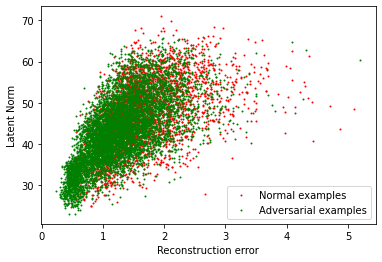

In [ ]:
# plt.scatter(error2,l_norm2,s=1)
plt.scatter(abc1,abc2, color='red', s=1)
plt.scatter(abc3,abc4, color='green', s=1)
plt.xlabel('Reconstruction error')
plt.ylabel('Latent Norm')
plt.legend(['Normal examples', 'Adversarial examples'])
plt.show()

In [ ]:
#Define the Convolutional Autoencoder
class ConvAutoencoder3(nn.Module):
    def __init__(self):
        super(ConvAutoencoder3, self).__init__()
        #Encoder
        self.conv1 = nn.Conv2d(8, 16, 3, padding=1)  
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
       
        #Decoder
        self.t_conv1 = nn.ConvTranspose2d(16, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 16, 2, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(16, 8, 2, stride=2)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # print('a',len(output), len(output[0]), len(output[0][0]), len(output[0][0][0]))
        # print('b11',len(x), len(x[0]), len(x[0][0]), len(x[0][0][0]))
        x = F.relu(self.conv2(x))
        # x = self.pool(x)
        # print('b12',len(x), len(x[0]), len(x[0][0]), len(x[0][0][0]))
        x = F.relu(self.conv3(x))
        x1 = self.pool(x)
        # print('b13',len(x1), len(x1[0]), len(x1[0][0]), len(x1[0][0][0]))
        x = F.relu(self.t_conv1(x1))
        # print('b14',len(x), len(x[0]), len(x[0][0]), len(x[0][0][0]))
        x = (F.relu(self.t_conv2(x)))
        # print('b15',len(x), len(x[0]), len(x[0][0]), len(x[0][0][0]))
        x = self.t_conv3(x)
        x = self.pool(x)
        return x,x1

In [ ]:
model_mid3 = ConvAutoencoder3()
optimizer = optim.Adam(model_mid3.parameters(), lr=0.001)
criterion = nn.MSELoss()
if torch.cuda.is_available():
    model_mid3 = model_mid3.cuda()
    criterion = criterion.cuda()

In [ ]:


for i in range(10):
    running_loss = 0
    for images, labels in trainloader:

        if torch.cuda.is_available():
          images = images.cuda()
          labels = labels.cuda()

        # reference = torch.zeros_like(images)
        # print(len(reference), len(reference[0]), len(reference[0][0]), len(reference[0][0][0]))
        
        # Training pass
        optimizer.zero_grad()
        
        output1 = model(images)
        # print('a',len(output), len(output[0]), len(output[0][0]), len(output[0][0][0]))
        # print('b',len(output1[1]), len(output1[1][0]), len(output1[1][0][0]), len(output1[1][0][0]))
        output,_ = model_mid3(output1[3])
        # print(output)
        # print(labels)
        # print('a',len(output), len(output[0]), len(output[0][0]), len(output[0][0][0]))
        # print('b',len(output1[1]), len(output1[1][0]), len(output1[1][0][0]), len(output1[1][0][0]))
        # break
        loss = criterion(output1[3], output)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(i+1, running_loss/len(trainloader)))
    

Epoch 1 - Training loss: 8.73646708998853
Epoch 2 - Training loss: 4.4686254928869475
Epoch 3 - Training loss: 3.525430502159509
Epoch 4 - Training loss: 3.1470433641344244
Epoch 5 - Training loss: 2.941738730300464
Epoch 6 - Training loss: 2.798897464900637
Epoch 7 - Training loss: 2.7034415817464086
Epoch 8 - Training loss: 2.63562434899019
Epoch 9 - Training loss: 2.5819985459862487
Epoch 10 - Training loss: 2.5438334143746384


In [ ]:
res = np.array([0,0,0,0])
correct_model2 = 0
adversaries = 0
nonadv = 0
abc1=[]
abc2=[]
abc3=[]
abc4=[]
for X,y in testloader:
    X,y = X.to(device), y.to(device)
    delta = fgsm(model, X, y, 0.1)
    for i in range(len(X)):
        # t1,t2=model((X[i]).reshape(1,1,28,28))
        # a = torch.argmax(t1).item()
        true = y[i]
        # print('ori', a )
        t1=model((X[i]+delta[i]).reshape(1,1,28,28))
        b = torch.argmax(t1[0]).item()
        # print('adv', b )
        # print(len(ref[0]),len(ref[0][0]),len(ref[0][0][0]),)
        # print(len(out),len(out[0]),len(out[0][0]),)
        # losses = np.array([nn.MSELoss()(ref[j].reshape(1,1,28,28),out) for j in range(len(ref))])
        # print(losses)
        # break
        # c = np.argmin(losses)

        # t1,t2=model(out.reshape(1,1,28,28))
        # c = torch.argmax(t1).item()
        # print('dec', c )
        # print('\n')
        if(true!=b):
            adversaries+=1
            t2,t3=model_mid3(t1[3])
            abc1.append(nn.MSELoss()(t2,t1[3]).detach().cpu())
            abc2.append(torch.norm(t3).detach().cpu())
        else:
            t2,t3=model_mid3(t1[3])
            abc3.append(nn.MSELoss()(t2,t1[3]).detach().cpu())
            abc4.append(torch.norm(t3).detach().cpu())
#                 res[0]+=1
#             else:
#                 res[1]+=1
#         else:
#             adversaries+=1
#             if(true==c):
#                 correct_model2+=1
#             if(b==c):
#                 res[2]+=1
#             else:
#                 res[3]+=1
# print(res, correct_model2, adversaries, nonadv)
'''0 - correct guess by both models 
1 - correct by model1 but wrong by model2 
2 - wrong by model1 but correct by model2 
3 - wrong by both models'''
print(adversaries)

3531


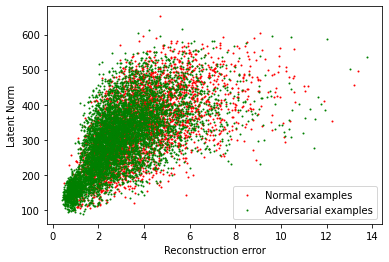

In [ ]:
# plt.scatter(error2,l_norm2,s=1)
plt.scatter(abc1,abc2, color='red', s=1)
plt.scatter(abc3,abc4, color='green', s=1)
plt.xlabel('Reconstruction error')
plt.ylabel('Latent Norm')
plt.legend(['Normal examples', 'Adversarial examples'])
plt.show()